Testing FIBSEM Microscope overall class
    - Testing Thermo Fisher instance of class
    

Importing Relevant Modules

In [2]:
%load_ext autoreload
%autoreload 2

import fibsem
from fibsem import utils, acquire
import fibsem.alignment as fa
from fibsem.structures import BeamType, ImageSettings, GammaSettings, FibsemRectangle, FibsemImage, check_data_format
import matplotlib.pyplot as plt
from fibsem import FibsemMicroscope, calibration
import os
import logging
from fibsem.utils import current_timestamp, configure_logging
from pathlib import Path
from autoscript_sdb_microscope_client.structures import (
    AdornedImage,
    GrabFrameSettings,
    Rectangle,
    RunAutoCbSettings,
)

Importing settings from config

In [5]:
settings = utils.load_settings_from_config()


Testing Setup 

In [7]:
microscope, settings = utils.setup_session()

[autoreload of fibsem.FibsemMicroscope failed: Traceback (most recent call last):
  File "c:\Users\lnae0002\Anaconda3\envs\fibsem\lib\site-packages\IPython\extensions\autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\lnae0002\Anaconda3\envs\fibsem\lib\site-packages\IPython\extensions\autoreload.py", line 459, in superreload
    module = reload(module)
  File "c:\Users\lnae0002\Anaconda3\envs\fibsem\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "C:\Users\lnae0002\Desktop\fibsem\fibsem\FibsemMicroscope.py", line 12, in <module>
    from tescanautomation import Automation
ModuleNotFoundError: No module named 'tescanautomation'
]


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\lnae0002\\Desktop\\fibsem\\config\\system.yaml'

Setting up for image acquisition

In [69]:
print(settings)

MicroscopeSettings(system=SystemSettings(ip_address='10.0.0.1', application_file='autolamella', stage=StageSettings(rotation_flat_to_electron=49, rotation_flat_to_ion=229, tilt_flat_to_electron=35, tilt_flat_to_ion=52, pre_tilt=35, needle_stage_height_limit=0.0037), ion=BeamSystemSettings(beam_type=<BeamType.ION: 2>, voltage=30000, current=2e-11, detector_type='ETD', detector_mode='SecondaryElectrons', eucentric_height=0.0165, plasma_gas='Argon'), electron=BeamSystemSettings(beam_type=<BeamType.ELECTRON: 1>, voltage=2000, current=1e-12, detector_type='ETD', detector_mode='SecondaryElectrons', eucentric_height=0.00391, plasma_gas='Null'), manufacturer='Thermo'), image=ImageSettings(resolution='1536x1024', dwell_time=1e-06, hfw=0.00015, autocontrast=True, beam_type=<BeamType.ELECTRON: 1>, save=False, label='default_image', gamma=GammaSettings(enabled=True, min_gamma=0.15, max_gamma=1.8, scale_factor=0.01, threshold=46), save_path='c:\\Users\\Admin\\Github\\fibsem\\demo_2022-12-07-10-24-4

In [70]:
# set gamma settings
gamma_settings = GammaSettings(
        enabled=True,
        min_gamma=0.5,
        max_gamma=1.8,
        scale_factor=0.01,
        threshold=46,
    )

# set imaging settings
image_settings = ImageSettings(
        resolution="1536x1024",
        dwell_time=1.0e-6,
        hfw=150.0e-6,
        autocontrast=True,
        beam_type=BeamType.ELECTRON,
        gamma=gamma_settings,
        save=True,
        save_path="fibsem\\test_images",
        label=utils.current_timestamp(),
        reduced_area=None,
    )


Autoconcrast

In [71]:
microscope.autocontrast(beam_type=image_settings.beam_type)
microscope.autocontrast(beam_type=BeamType.ION)


Take new image

2022-12-07 10:25:51,306 — root — INFO — acquire_image:100 — acquiring new ELECTRON image.


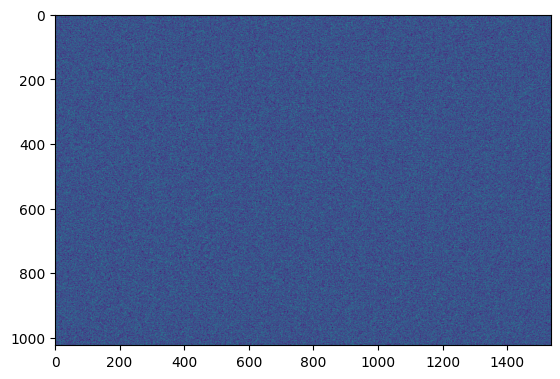

In [74]:
new_image = acquire.new_image(microscope, image_settings)

plt.imshow(new_image.data)
plt.show()


Checks

In [76]:
assert isinstance(new_image, FibsemImage)
assert check_data_format(new_image.data)

assert new_image.metadata.compare_image_settings(image_settings)
assert new_image.metadata.version == 'v1'
assert os.path.exists(f"{os.path.join(image_settings.save_path, image_settings.label)}_eb.tif")
assert new_image.metadata.microscope_state.absolute_position == microscope.get_stage_position()

print(new_image.metadata.microscope_state)

MicroscopeState(timestamp='12/07/2022 10:38:15', absolute_position=StagePosition(x=-0.01551275, y=0.052503417, z=0.023156668, t=-5.0732825e-06, r=0.85522671, coordinate_system=Raw), eb_settings=BeamSettings(beam_type=<BeamType.ELECTRON: 1>, working_distance=0.015681205023864025, beam_current=5e-11, hfw=0.00015, resolution='1536x1024', dwell_time=1e-06, stigmation=None, shift=None), ib_settings=BeamSettings(beam_type=<BeamType.ION: 2>, working_distance=0.0165, beam_current=2e-11, hfw=0.00015, resolution='1536x1024', dwell_time=1e-06, stigmation=None, shift=None))


Take last image

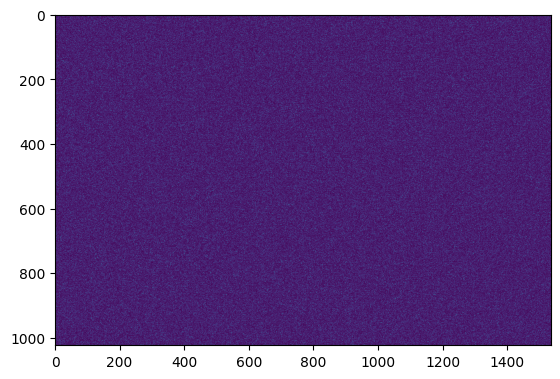

In [77]:
label = f"{image_settings.label}_last"

last_image = microscope.last_image(image_settings.beam_type)

plt.imshow(last_image.data)
plt.show()

if image_settings.save:
    filename = os.path.join(image_settings.save_path, label)
    last_image.save(save_path=filename)


Checks

In [78]:
# assert isinstance(last_image, FibsemImage)
assert check_data_format(last_image.data)


# assert last_image.metadata.compare_image_settings(image_settings) # TODO: FIX THIS, different than img settings
assert last_image.metadata.version == 'v1'
assert os.path.exists(f"{filename}.tif")

print(last_image.metadata.microscope_state)

MicroscopeState(timestamp='12/07/2022 10:38:15', absolute_position=StagePosition(x=-0.01551275, y=0.052503417, z=0.023156668, t=-5.0732825e-06, r=0.85522671, coordinate_system=Raw), eb_settings=BeamSettings(beam_type=<BeamType.ELECTRON: 1>, working_distance=0.015681205023864025, beam_current=5e-11, hfw=0.00015, resolution='1536x1024', dwell_time=1e-06, stigmation=None, shift=None), ib_settings=BeamSettings(beam_type=<BeamType.ION: 2>, working_distance=0.0165, beam_current=2e-11, hfw=0.00015, resolution='1536x1024', dwell_time=1e-06, stigmation=None, shift=None))


Take reference images

2022-12-07 10:26:26,715 — root — INFO — acquire_image:100 — acquiring new ELECTRON image.
2022-12-07 10:26:29,090 — root — INFO — acquire_image:100 — acquiring new ION image.
2022-12-07 10:26:31,546 — root — INFO — acquire_image:100 — acquiring new ELECTRON image.
2022-12-07 10:26:34,004 — root — INFO — acquire_image:100 — acquiring new ION image.
ReferenceImages(low_res_eb=<fibsem.structures.FibsemImage object at 0x000002B37651D490>, high_res_eb=<fibsem.structures.FibsemImage object at 0x000002B3753734F0>, low_res_ib=<fibsem.structures.FibsemImage object at 0x000002B37594FC70>, high_res_ib=<fibsem.structures.FibsemImage object at 0x000002B36A4656D0>)


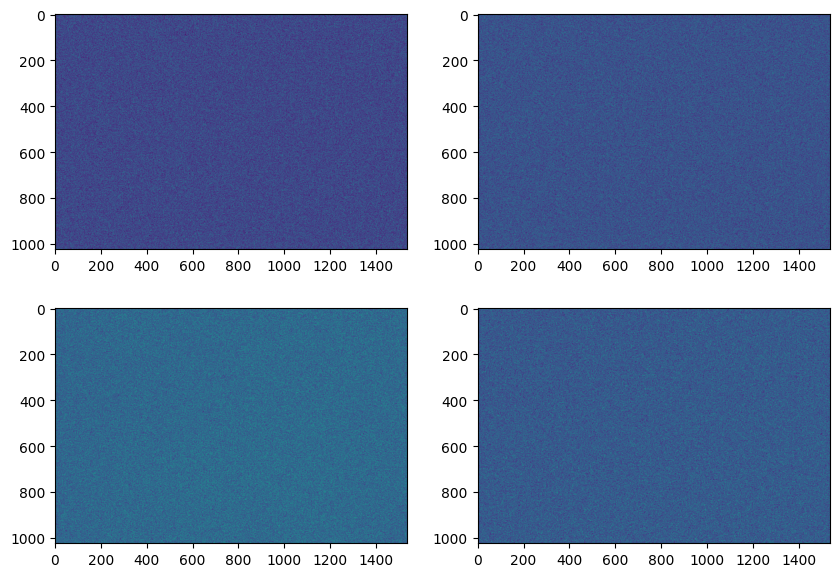

In [79]:
#taking set of ref images
hfws =  [400e-6, 150.0e-6]
ref_images = acquire.take_set_of_reference_images(microscope, image_settings,hfws)
fig = plt.figure(figsize=(10, 7))

print(ref_images)

fig.add_subplot(2, 2, 1)
plt.imshow(ref_images.low_res_eb.data)
fig.add_subplot(2, 2, 2)
plt.imshow(ref_images.high_res_eb.data)
fig.add_subplot(2, 2, 3)
plt.imshow(ref_images.low_res_ib.data)
fig.add_subplot(2, 2, 4)
plt.imshow(ref_images.high_res_ib.data)

#checking image data 
# if ref_images.low_res_eb.metadata.compare_image_settings(image_settings):
#     print("Image settings are the same")
# print(ref_images[0].metadata.microscope_state.timestamp)
# print(ref_images[0].metadata.version)


assert ref_images.low_res_eb.metadata.image_settings.hfw == hfws[0], f"hfw: {ref_images.low_res_eb.metadata.image_settings.hfw} != {hfws[0]}"
assert ref_images.low_res_ib.metadata.image_settings.hfw == hfws[0], f"hfw: {ref_images.low_res_ib.metadata.image_settings.hfw} != {hfws[0]}"
assert ref_images.high_res_eb.metadata.image_settings.hfw == hfws[1], f"hfw: {ref_images.high_res_eb.metadata.image_settings.hfw} != {hfws[1]}"
assert ref_images.high_res_ib.metadata.image_settings.hfw == hfws[1], f"hfw: {ref_images.high_res_ib.metadata.image_settings.hfw} != {hfws[1]}"


Beam shift

In [80]:
print("electron: ", microscope.connection.beams.electron_beam.beam_shift.value)
print("ion: ", microscope.connection.beams.ion_beam.beam_shift.value)

microscope.reset_beam_shifts()

print("electron: ", microscope.connection.beams.electron_beam.beam_shift.value)
print("ion: ", microscope.connection.beams.ion_beam.beam_shift.value)

assert microscope.connection.beams.electron_beam.beam_shift.value.x == 0
assert microscope.connection.beams.electron_beam.beam_shift.value.y ==  0

assert microscope.connection.beams.ion_beam.beam_shift.value.x == 0
assert microscope.connection.beams.ion_beam.beam_shift.value.y ==  0

electron:  Point(x=0, y=0)
ion:  Point(x=0, y=0)
electron:  Point(x=0, y=0)
ion:  Point(x=0, y=0)


Disconnect from Microscope

In [81]:
microscope.disconnect()

Client disconnected
